In [1]:
import os
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [2]:
#load data and labels
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
label_map_path  = os.path.join(data_dir,'label_num_to_phase_map.json')
train_csv = os.path.join(data_dir, 'train.csv')
test_csv = os.path.join(data_dir, 'test.csv')
IMG_SIZE = (224, 224)

# load label number to phase name mapping
with open(label_map_path, 'r') as f:
    label_map = json.load(f)

# Invert dictionary to look up label names by number
label_num_to_name = {int(v): k for k, v in label_map.items()}


In [3]:
#load csv
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [4]:
# helper to load and preprocess images
def load_images_and_labels(df, folder):
    images = []
    labels = []
    for i, row in df.iterrows():
        img_path = os.path.join(folder, row['image_id'])
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

In [5]:
#load train/test sets
X_train, y_train = load_images_and_labels(train_df, train_dir)
X_test, y_test = load_images_and_labels(test_df, test_dir)

In [6]:
# number of layers to keep from ResNet50
NUM_LAYERS_TO_KEEP = 160
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
layer_output = base_model.layers[NUM_LAYERS_TO_KEEP].output
feature_extractor = Model(inputs=base_model.input, outputs=layer_output)

In [7]:
# pooling
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=feature_extractor.input, outputs=x)

# fine-tune last n layers of ResNet50 layers kept
NUM_LAYERS_TO_UNFREEZE = 30

# all layers to non-trainable first
for layer in model.layers:
    layer.trainable = False

# unfreeze last n layers
for layer in model.layers[-NUM_LAYERS_TO_UNFREEZE:]:
    layer.trainable = True

In [8]:
# extract features
X_train_feats = model.predict(X_train, batch_size=32)
X_test_feats = model.predict(X_test, batch_size=32)

5/5 [==============================] - 0s 37ms/step


In [9]:
# normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feats)
X_test_scaled = scaler.transform(X_test_feats)

In [10]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=135,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [11]:
# build model with fine-tuning

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = model(inputs, training=False)  # freeze base initially
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(8, activation='softmax')(x)

finetuned_model = Model(inputs, outputs)

# compile with a lower learning rate
finetuned_model.compile(optimizer=Adam(learning_rate=1e-4),  # fine-tuning = low LR
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# train with early stopping
finetuned_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs = 30,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/30
16/16 [==============================] - 7s 262ms/step - loss: 1.6364 - accuracy: 0.4263 - val_loss: 1.2086 - val_accuracy: 0.5500
Epoch 2/30
16/16 [==============================] - 4s 222ms/step - loss: 1.1963 - accuracy: 0.5737 - val_loss: 0.9126 - val_accuracy: 0.7286
Epoch 3/30
16/16 [==============================] - 4s 223ms/step - loss: 0.8883 - accuracy: 0.7051 - val_loss: 0.6230 - val_accuracy: 0.7571
Epoch 4/30
16/16 [==============================] - 4s 223ms/step - loss: 0.7198 - accuracy: 0.7394 - val_loss: 0.5984 - val_accuracy: 0.7357
Epoch 5/30
16/16 [==============================] - 4s 221ms/step - loss: 0.5776 - accuracy: 0.8040 - val_loss: 0.3944 - val_accuracy: 0.8643
Epoch 6/30
16/16 [==============================] - 3s 224ms/step - loss: 0.5136 - accuracy: 0.8101 - val_loss: 0.5789 - val_accuracy: 0.7643
Epoch 7/30
16/16 [==============================] - 4s 219ms/step - loss: 0.5115 - accuracy: 0.8242 - val_loss: 0.4189 - val_accuracy: 0.8429
Epoch 

In [12]:
# evaluate fine-tuned custom model
finetuned_preds = np.argmax(finetuned_model.predict(X_test), axis=1)
finetuned_acc = accuracy_score(y_test, finetuned_preds)

5/5 [==============================] - 1s 31ms/step


In [13]:
#train classifiers
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
log_preds = log_reg.predict(X_test_scaled)
log_acc = accuracy_score(y_test, log_preds)

svm = SVC()
svm.fit(X_train_scaled, y_train)
svm_preds = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_preds)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_preds = knn.predict(X_test_scaled)
knn_acc = accuracy_score(y_test, knn_preds)

In [14]:
#print results
print(f"Fine-tuned Custom Model Accuracy: {finetuned_acc:.4f}")
print(f"Logistic Regression Accuracy: {log_acc:.4f}")
print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"KNN Accuracy: {knn_acc:.4f}")

Fine-tuned Custom Model Accuracy: 0.9286
Logistic Regression Accuracy: 0.8286
SVM Accuracy: 0.8071
KNN Accuracy: 0.7286


In [15]:
# confusion matrix plotting
def plot_confusion_matrix(predictions, true_labels, title):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {title}")
    plt.tight_layout()
    plt.show()

<Figure size 1000x800 with 0 Axes>

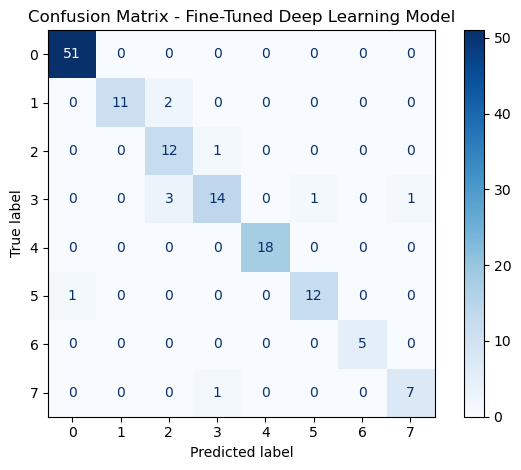

<Figure size 1000x800 with 0 Axes>

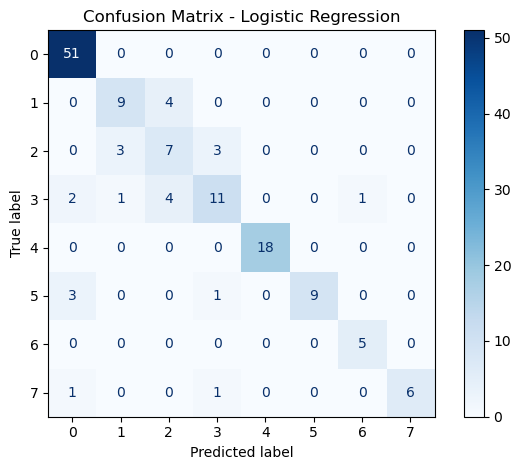

<Figure size 1000x800 with 0 Axes>

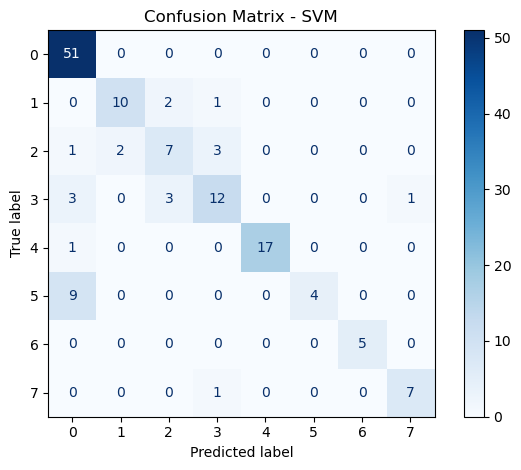

<Figure size 1000x800 with 0 Axes>

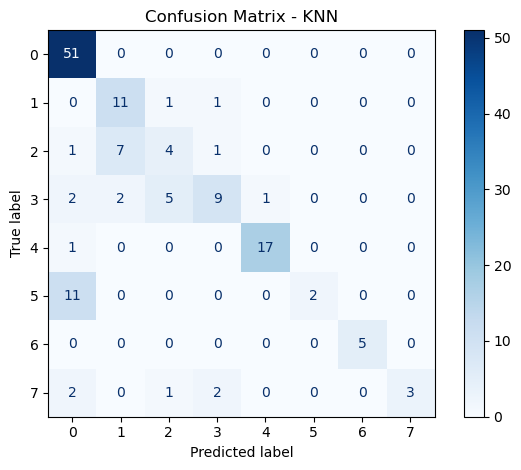

In [16]:
# confusion matrices
plot_confusion_matrix(finetuned_preds, y_test, "Fine-Tuned Deep Learning Model")
plot_confusion_matrix(log_preds, y_test, "Logistic Regression")
plot_confusion_matrix(svm_preds, y_test, "SVM")
plot_confusion_matrix(knn_preds, y_test, "KNN")

In [17]:
# classification reports
print("\nClassification Report - Fine-tuned Custom Model")
print(classification_report(y_test, finetuned_preds))

print("\nClassification Report - Logistic Regression")
print(classification_report(y_test, log_preds))

print("\nClassification Report - SVM")
print(classification_report(y_test, svm_preds))

print("\nClassification Report - KNN")
print(classification_report(y_test, knn_preds))


Classification Report - Fine-tuned Custom Model
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       1.00      0.85      0.92        13
           2       0.71      0.92      0.80        13
           3       0.88      0.74      0.80        19
           4       1.00      1.00      1.00        18
           5       0.92      0.92      0.92        13
           6       1.00      1.00      1.00         5
           7       0.88      0.88      0.88         8

    accuracy                           0.93       140
   macro avg       0.92      0.91      0.91       140
weighted avg       0.93      0.93      0.93       140


Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        51
           1       0.69      0.69      0.69        13
           2       0.47      0.54      0.50        13
           3       0.69      0.58     


Total misclassified images: 10


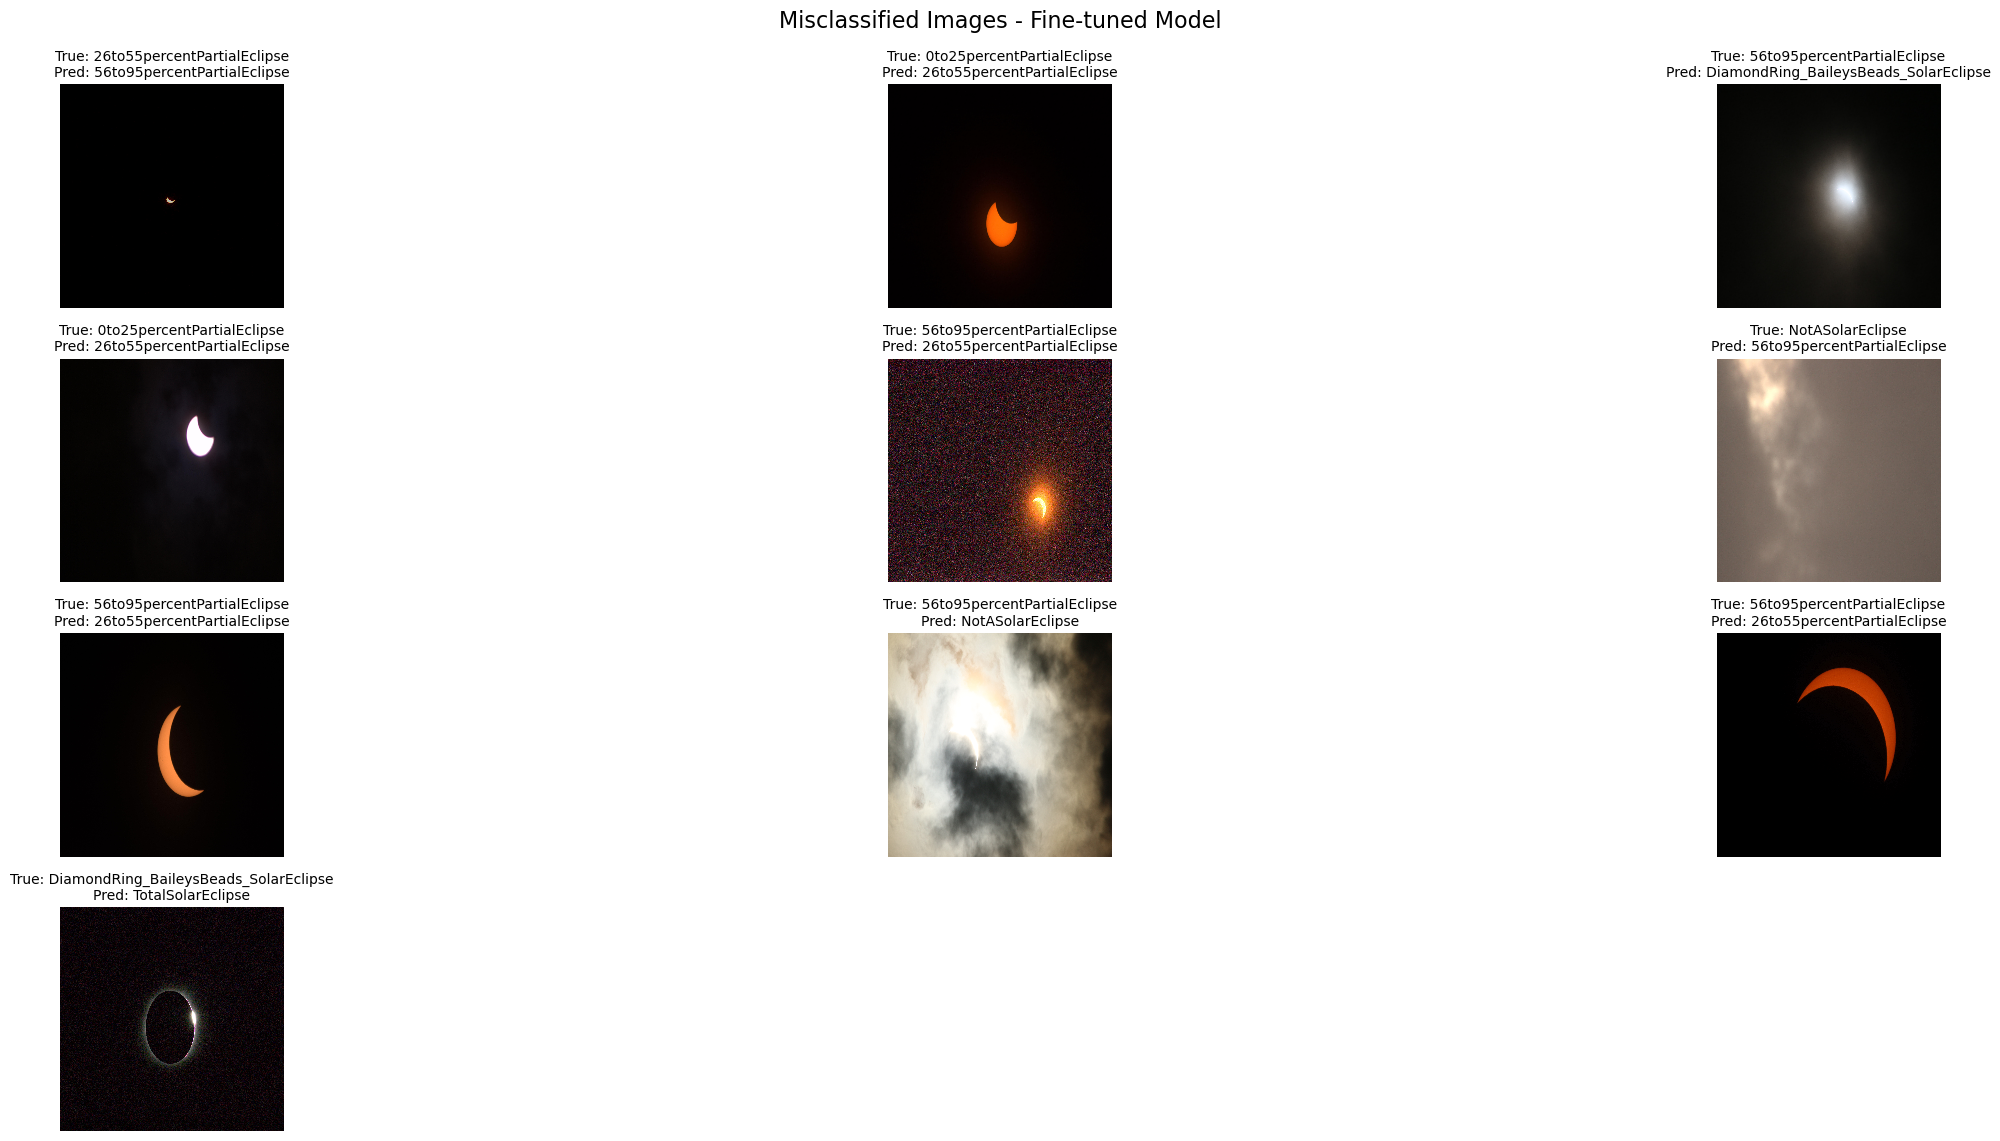

In [18]:
# show misclassified test images with label names
misclassified_indices = np.where(finetuned_preds != y_test)[0]
print(f"\nTotal misclassified images: {len(misclassified_indices)}")

num_to_show = min(21, len(misclassified_indices))
plt.figure(figsize=(25, 20))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(7, 3, i + 1)
    img = X_test[idx].astype("uint8")
    true_label = label_num_to_name[y_test[idx]]
    pred_label = label_num_to_name[finetuned_preds[idx]]
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis('off')

plt.suptitle("Misclassified Images - Fine-tuned Model\n", fontsize=16)
plt.tight_layout()
plt.show()
